In [45]:
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
import time
import torch

In [46]:
from src.whisper_streaming.silero_vad_iterator import FixedVADIterator, VADIterator


In [75]:
import torch

model, _ = torch.hub.load(repo_or_dir="snakers4/silero-vad", model="silero_vad")

model = model.to("mps")
# vac = FixedVADIterator(model)

vac = VADIterator(model) # 512 frames only

Using cache found in /Users/silas/.cache/torch/hub/snakers4_silero-vad_master


In [71]:
from src.whisper_streaming.backends import MLXWhisper

whisper= MLXWhisper(lan="fr",modelsize="large-v3-turbo")

I finish. Commit non-commited: 12.816-14.856:  qu'à mon arrivée, je ne vous ne vous trouvez pas vous.


I finish. Commit non-commited: 53.136-56.096:  spirituelle qui nécessite des pathologie spirituelle.


22:13:42.671706[DEBUG]: VAC detected end 15.94s
22:13:42.677073[WARNING]: I finish. Commit non-commited: 12.816-14.856:  qu'à mon arrivée, je ne vous ne vous trouvez pas vous.

vac -> 90176

buffer offset= 96640

In [72]:
from src.whisper.audio import load_audio_chunk

SAMPLING_RATE = 16000

audio_chunk = load_audio_chunk("mydata/preche_JB.wav",8.796,16.94)

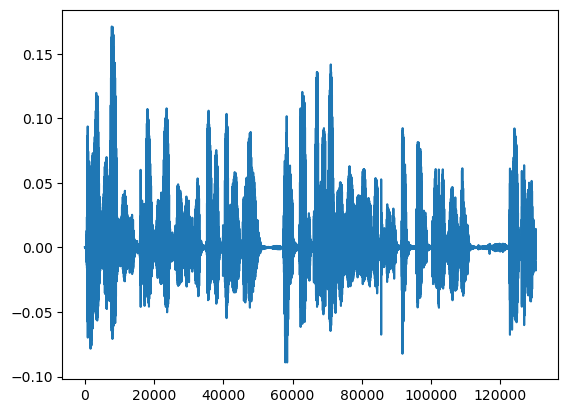

In [73]:
# play audio
plt.plot(audio_chunk)

#sd.play(audio_chunk, SAMPLING_RATE)

In [51]:
res=whisper.transcribe(audio_chunk)
tsw = whisper.ts_words(res)

"".join(t[2] for t in tsw)

" Je vous l'avoue, dit Paul aux Corinthiens, j'ai peur qu'à mon arrivée, je ne vous trouve pas telle que je voudrais.! Je crains de vous."

In [77]:


vac.reset_states()

chunk_length= 512

Positions=[]
speech_segments=[]
state="nonvoice"


start_time=time.time()

for i in range(0, len(audio_chunk), chunk_length):
    offset=i
    segment = audio_chunk[i:i+chunk_length]

    if len(segment)!=chunk_length:
        print(f"Warning: segment {i} is {len(segment)} length is not {chunk_length}")
    
        break
        
    tensor= torch.tensor(segment).to("mps")
    vac_res= vac(tensor)
    if vac_res is not None:
        assert len(vac_res)==1
        print(i)
        print(vac_res)
        
        Positions.append(vac_res)

        position_in_chunk = vac_res[ list(vac_res.keys())[0] ] - offset + chunk_length

        
        if "start" in vac_res:
            assert state=="nonvoice"
            state="voice"
            speech_segment= segment[position_in_chunk:]
            
        elif "end" in vac_res:
            assert state=="voice"
            state="nonvoice"
            speech_segment= np.concatenate([speech_segment, segment[:position_in_chunk]])

            speech_segments.append(speech_segment)
            speech_segment=np.array([])
    
    elif state=="voice":
        speech_segment= np.concatenate([speech_segment,segment])

end_time=time.time()

print("Time elapsed: ", end_time-start_time)


[len(x) for x in speech_segments]

NotImplementedError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "<string>", line 47, in <forward op>
            p1m = (1. - p) * float(train)
            scale = 1. / (float(p1m == 0.) + p1m)
            res,mask = torch.native_dropout(input, p, train)
                       ~~~~~~~~~~~~~~~~~~~~ <--- HERE

            def backward(grad_output):
RuntimeError: The operator 'aten::native_dropout' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.



Fixed VAC is 2 ms slower

In [ ]:
sd.play(speech_segments[0], SAMPLING_RATE)

In [33]:
for s in speech_segments:
    #sd.play(s, SAMPLING_RATE)
    res= whisper.transcribe(s)
    tsw = whisper.ts_words(res)

    print("".join(t[2] for t in tsw))

 Je vous l'avoue, dit Paul au Corinthien, j'ai peur qu'à mon arrivée, je ne vous trouve pas telle que je voudrais.


/var/folders/9m/6ssqsbns25378yyyg803ccbw0000gn/T/ipykernel_50966/3118238405.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ =ax.set_xticklabels([str(int(x/SAMPLING_RATE)) for x in xticks])


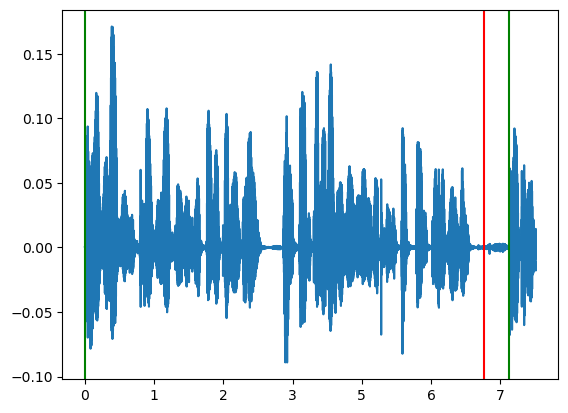

In [32]:
plt.plot(audio_chunk)

for vac_res in Positions:
    assert len(vac_res) == 1
    key= list(vac_res.keys())[0]


    color = "green" if key=="start" else "red"
    pos = vac_res[key]+ chunk_length 
    plt.axvline(pos,color=color)
        


# scale x axis tick labels to seconds by deviding by the sampling rate
ax = plt.gca()
xticks = ax.get_xticks()
_ =ax.set_xticklabels([str(int(x/SAMPLING_RATE)) for x in xticks])

